# Project: Write a Data Science Blog Post
This notebook is used to summarise all the pipeline done for this project.

You will be able to find a post on Medium following this notebook (see README file for link)

## Section 1 - Business Understanding
The goal of this project is to predict the survivality of people on the Titanic, using different models.

For that, we have the following 4 questions:

1. Question 1: Did the "Women and children first" have a real impact on the probability of survival of someone?
2. Question 2: Was there really a link between which ticket class you took and your survival?
3. Question 3: Which model has the highest score in Kaggle?
4. Question 4: What are the most important features of an EBM?

### Packages
We have the following packages we are importing

In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# modelling
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from interpret.glassbox import ExplainableBoostingRegressor
from interpret import set_visualize_provider, show
from interpret.provider import InlineProvider
from xgboost import XGBRegressor, plot_importance

# homemade functions
from utils.plot import plot_hist

# set visualising provider for EBMs
set_visualize_provider(InlineProvider())

## Utils
In here, we will define all folders necessary for this project

In [16]:
# create folder structure for outputs
output_submissions = os.path.join(
    "outputs",
    "submissions")

# check if the folders exist - else create them
if not os.path.exists(output_submissions):
    os.makedirs(output_submissions)

## Section 2 - Data Understanding

In this section, we will investigate the data in more details, trying to see if there is any need of cleaning / preparation.

### 2.1 Import

In [17]:
train = pd.read_csv("data/train.csv") 
train['sample'] = 'train'
test = pd.read_csv("data/test.csv")
test['sample'] = 'test'

modelling_data = pd.concat([train,test], axis = 0)

### 2.2 Data Exploration

In [18]:
# see the first rows
modelling_data.head()

PassengerId  Survived  Pclass  \
0            1       0.0       3   
1            2       1.0       1   
2            3       1.0       3   
3            4       1.0       1   
4            5       0.0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked sample  
0      0         A/5 21171   7.2500   NaN        S  train  
1      0          PC 17599  71.2833   C85        C  train  
2      0  STON/O2. 3101282   7.9250   NaN        S  train  
3      0            113803  53.1000  C123        S  train  
4      0            373450   8.0500   NaN        S  train

In [19]:
# see the number of non-null values and types of each column
modelling_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
 12  sample       1309 non-null   object 
dtypes: float64(3), int64(4), object(6)
memory usage: 143.2+ KB


we see that Survived has many nulls - which make sense as all of them come from the test data.

Age has many null values, Embarked 2 and Fare 1. 

Nearly 80% of the rows have missing Cabin. We will have to do something about it!

In [20]:
# Let's see the distribution of all numerical columns
modelling_data.describe()

PassengerId    Survived       Pclass          Age        SibSp  \
count  1309.000000  891.000000  1309.000000  1046.000000  1309.000000   
mean    655.000000    0.383838     2.294882    29.881138     0.498854   
std     378.020061    0.486592     0.837836    14.413493     1.041658   
min       1.000000    0.000000     1.000000     0.170000     0.000000   
25%     328.000000    0.000000     2.000000    21.000000     0.000000   
50%     655.000000    0.000000     3.000000    28.000000     0.000000   
75%     982.000000    1.000000     3.000000    39.000000     1.000000   
max    1309.000000    1.000000     3.000000    80.000000     8.000000   

             Parch         Fare  
count  1309.000000  1308.000000  
mean      0.385027    33.295479  
std       0.865560    51.758668  
min       0.000000     0.000000  
25%       0.000000     7.895800  
50%       0.000000    14.454200  
75%       0.000000    31.275000  
max       9.000000   512.329200

On top of that, we see that most of the time we have:
- Passengers didn't survive
- Passengers were coming from third class
- The average age is roughly similar to the median (28y), but with a high std. We have a high distribution of ages. Would be interested to look at it.
- Most Passengers didn't have any siblings, spouses nor parents/children
- Most of the Fares are very low, but we have a very high max. Would be interested to look at it in more details.

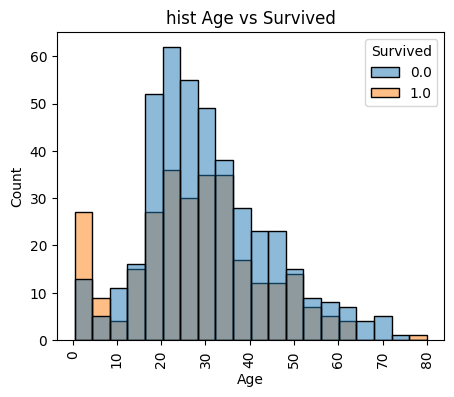

In [21]:
# Let's look at Age's distribution
plot_hist(
    df = modelling_data,
    var_to_plot = "Age",
    var_hue = "Survived",
    save_fig = False,
    save_location=None
)

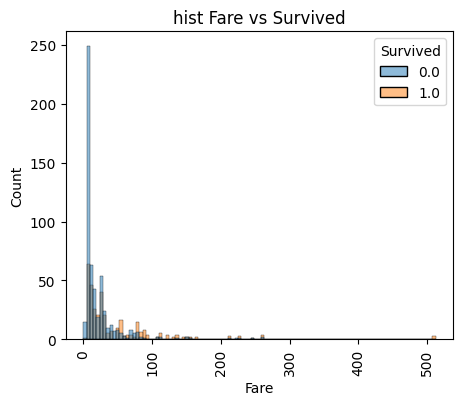

In [22]:
# Let's look at Fare's distribution
plot_hist(
    df = modelling_data,
    var_to_plot = "Fare",
    var_hue = "Survived",
    save_fig = False,
    save_location=None
)
# Seems that most Fare is <100, but we have some values that are 200-275 or 500 pounds

In [23]:
# we can see that less than 5% are above 133 pounds
cap_fare = np.quantile(modelling_data['Fare'][~modelling_data['Fare'].isna()],0.99)
cap_fare

262.375

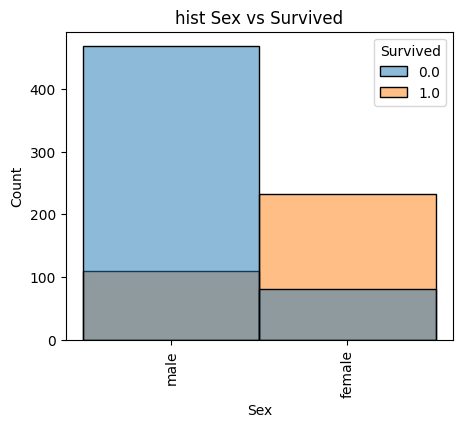

In [24]:
# Let's look at what happens per gender
plot_hist(
    df = modelling_data,
    var_to_plot = "Sex",
    var_hue = "Survived",
    save_fig = False,
    save_location=None
)
# More female survived than males. Make sense with the "Women and Children First" rule.

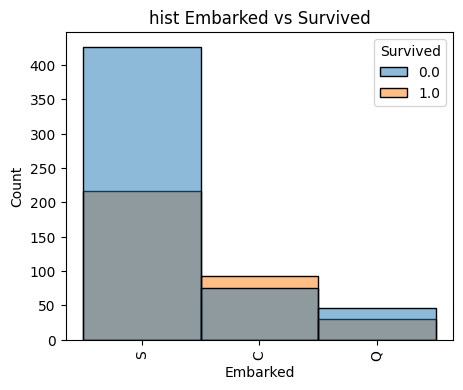

In [25]:
# Let's look at the distribution of Embarked values
plot_hist(
    df = modelling_data,
    var_to_plot = "Embarked",
    var_hue = "Survived",
    save_fig = False,
    save_location=None
)

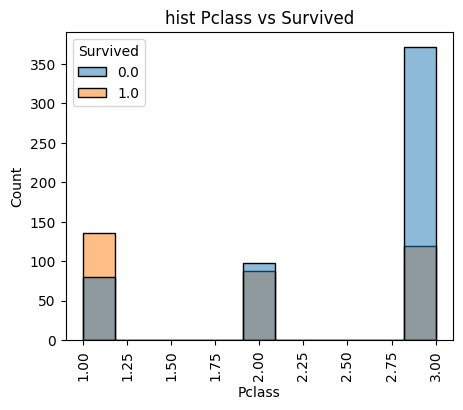

In [26]:
# Let's look at the distribution of Class values
plot_hist(
    df = modelling_data,
    var_to_plot = "Pclass",
    var_hue = "Survived",
    save_fig = False,
    save_location=None
)

In [27]:
# The Ticket column seems difficult to understand its impact. 
# We will remove it from our features.
print(modelling_data['Ticket'].value_counts())
modelling_data.drop(
    ['Ticket'],
    axis = 1,
    inplace = True
)

CA. 2343        11
CA 2144          8
1601             8
PC 17608         7
S.O.C. 14879     7
                ..
113792           1
36209            1
323592           1
315089           1
359309           1
Name: Ticket, Length: 929, dtype: int64


## Section 3 - Prepare Data

### 3.1 Embarked column
As said above, we have only 2 missing values in the column Embarked. We fill them with the value "S", which is the most common.

In [28]:
modelling_data = modelling_data.fillna(value = {"Embarked" : "S"})

### 3.2 Name column
While the names are a bit too random for the model we may want to create, we could maybe separate the names by first/last names and titles.

In [29]:
modelling_data[['LastName','FirstName']] = modelling_data['Name'].str.split(',', n = 1,expand = True)
modelling_data[['Title','FirstNames']] = modelling_data['FirstName'].str.split('.', n = 1,expand = True)
modelling_data['Title'] = modelling_data['Title'].str.replace(" ","")

modelling_data.drop(
    ['Name','FirstName','LastName','FirstNames'],
    axis = 1,
    inplace = True
)

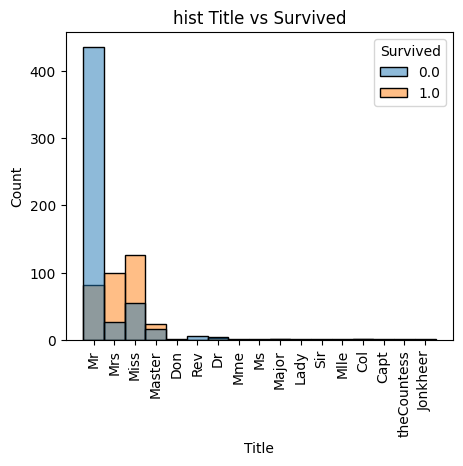

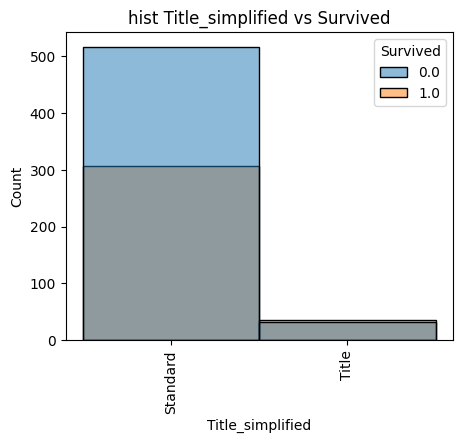

In [30]:
# Let's see what happens now with the titles:
plot_hist(
    df = modelling_data,
    var_to_plot = "Title",
    var_hue = "Survived",
    save_fig = False,
    save_location=None
)
# Seems interesting, but maybe we could simplify the Title
modelling_data['Title_simplified'] = np.where(
    modelling_data['Title'].isin(['Mr','Mrs','Miss']),
    'Standard',
    'Title'
)
plot_hist(
    df = modelling_data,
    var_to_plot = "Title_simplified",
    var_hue = "Survived",
    save_fig = False,
    save_location=None
)

Due to the low volume and the correlation between most of the titles and the gender of a passenger, we remove these features from the data

In [31]:
modelling_data.drop(
    ['Title','Title_simplified'],
    axis = 1,
    inplace = True
)

### 3.3 Cabin column
As said above, the cabin column is ~80% empty. To still be able to bring some value from this feature, we will replace it with a column that says if the Cabin value was empty or not.

In [32]:
modelling_data["Cabin_NA"] = modelling_data.Cabin.isna().astype(int)
modelling_data.drop(["Cabin"], axis = 1, inplace = True)

### 3.4 Remove missing data
As said in section 2 we have some missing data. We replace the missing ages and Fares with their median


In [33]:
modelling_data['Age'] = modelling_data['Age'].\
    fillna(modelling_data['Age'].median()).\
        round(decimals = 0)
modelling_data["Fare"] = modelling_data['Fare'].\
    fillna(modelling_data['Fare'].median()).\
        round(decimals = 0)

### 3.5 One hot encoding
For the categorical variables plus Pclass and Cabin_NA, we change them into numerical with OHE.

In [34]:
modelling_data.dtypes

PassengerId      int64
Survived       float64
Pclass           int64
Sex             object
Age            float64
SibSp            int64
Parch            int64
Fare           float64
Embarked        object
sample          object
Cabin_NA         int32
dtype: object

In [35]:
# features to encode as categorical
features_to_ohe = ["Pclass", "Sex", "Embarked",  "Cabin_NA"]
modelling_data[features_to_ohe] = modelling_data[features_to_ohe].apply(lambda x: x.astype("category"))

# set up the encoder
ohe = OneHotEncoder(sparse = False,
                    handle_unknown = 'error',
                    drop = 'first')
ohe = ohe.fit(modelling_data[features_to_ohe])

# output of encoder
index_name = str(modelling_data.index.name)
transformed = pd.DataFrame(ohe.transform(modelling_data[features_to_ohe]))
transformed.columns = ohe.get_feature_names_out(features_to_ohe)

# put things back together
modelling_data = pd.concat([modelling_data.reset_index(drop = True),
                            transformed.reset_index(drop = True)],
                            axis = 1)
# delete input columns
modelling_data.drop(features_to_ohe,
                    axis = 1,
                    inplace = True)

### 3.6 Separation samples
Finally, we separate the 2 samples to train our model only on the sample containing the Survived results.

In [36]:
train = modelling_data[modelling_data['sample'] == 'train'].copy()
test = modelling_data[modelling_data['sample'] == 'test'].copy()

train.drop(
    ['sample','PassengerId'],
    axis = 1,
    inplace = True
)
test.drop(
    ['sample'],
    axis = 1,
    inplace = True
)

del modelling_data

In [37]:
train.head()

Survived   Age  SibSp  Parch  Fare  Pclass_2  Pclass_3  Sex_male  \
0       0.0  22.0      1      0   7.0       0.0       1.0       1.0   
1       1.0  38.0      1      0  71.0       0.0       0.0       0.0   
2       1.0  26.0      0      0   8.0       0.0       1.0       0.0   
3       1.0  35.0      1      0  53.0       0.0       0.0       0.0   
4       0.0  35.0      0      0   8.0       0.0       1.0       1.0   

   Embarked_Q  Embarked_S  Cabin_NA_1  
0         0.0         1.0         1.0  
1         0.0         0.0         0.0  
2         0.0         1.0         1.0  
3         0.0         1.0         0.0  
4         0.0         1.0         1.0

## Section 4 - Modelling

In [38]:
# Let's separate the features from the target
X = train.drop(['Survived'], axis = 1, inplace = False)
y = train["Survived"]

features = X.columns

# Let's create a validation set to remove some ovefitting
X_train,X_validation,y_train,y_validation = train_test_split(
    X,
    y,
    test_size = 0.2,
    random_state = 42,
    shuffle = True)

### 4.1 Model 1 - GLM with Pipeline
For a first model, we will use a GLM with a GridSearch to optimise the parameters.

In [39]:
#init models
std_slc = StandardScaler()
logistic_reg = linear_model.LogisticRegression()
# set up a pipeline
pipe = Pipeline(steps = [
    ('std_slc' , std_slc),
    ('logistic_reg', logistic_reg)
    ])

# define parameters
params={"logistic_reg__C": np.logspace(-4, 4, 50) }

# optimise
glm_model = GridSearchCV(pipe,
                    params,
                    cv = 10,
                    n_jobs = -1,
                    verbose = 1)

# fit
glm_model.fit(X_train, y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('std_slc', StandardScaler()),
                                       ('logistic_reg', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logistic_reg__C': array([1.00000000e-04, 1.45634848e-04, 2.12095089e-04, 3.08884360e-04,
       4.49843267e-04, 6.55128557e-04, 9.54095476e-04, 1.38949549e-03,
       2.02358965e-03, 2.94705170e-03, 4.29193426e-03, 6.25055193e-03,
       9.1029817...
       8.28642773e-01, 1.20679264e+00, 1.75751062e+00, 2.55954792e+00,
       3.72759372e+00, 5.42867544e+00, 7.90604321e+00, 1.15139540e+01,
       1.67683294e+01, 2.44205309e+01, 3.55648031e+01, 5.17947468e+01,
       7.54312006e+01, 1.09854114e+02, 1.59985872e+02, 2.32995181e+02,
       3.39322177e+02, 4.94171336e+02, 7.19685673e+02, 1.04811313e+03,
       1.52641797e+03, 2.22299648e+03, 3.23745754e+03, 4.71486636e+03,
       6.86648845e+03, 1.00000000e+04])},
             verbose=1)

### 4.2 Model 2 - Explainable Boosting Machine
Let's train an EBM now.

In [40]:
#init models
ebm = ExplainableBoostingRegressor(random_state = 42)
# set up paramters
params={
    "learning_rate":[0, 0.005, 0.01, 0.015, 0.02],
    "max_leaves":[3,4,5,6,7],
}
# optimise
ebm_model = GridSearchCV(ebm,
                    params,
                    cv = 5,
                    n_jobs = -1,
                    verbose = 1)
ebm_model.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(cv=5, estimator=ExplainableBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0, 0.005, 0.01, 0.015, 0.02],
                         'max_leaves': [3, 4, 5, 6, 7]},
             verbose=1)

### 4.3 Model 3 - XGBoost
Finally, let's train an XGB.

In [41]:
# init model
xgb = XGBRegressor()
# set up parameters possibilities
params={"eta":[0.05,0.1,0.2,0.3],
        "gamma":[0,0.01,0.1,0.15,0.2],
        "max_depth":[3,4,5,6,7]
       }
gbm_model = GridSearchCV(xgb,
                    params,
                    cv = 5,
                    n_jobs = -1,
                    verbose = 1)
gbm_model.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None, ...),
             n_jobs=-1,
             param_grid={'eta': [0.05, 0.1, 0.2, 0.3],
                         'gamma': [0, 0.01, 0.1, 0.15, 0.2],
                         'max_depth': [3, 4, 5, 6, 7]},
             verbose=1)

### 4.4 Validation
Let's validate the models to see which ones are better

In [42]:
models = {
    'glm' : glm_model,
    'ebm' : ebm_model,
    'xgb' : gbm_model
}

In [43]:
# Let's look at the accuracy of the models
for type, model in models.items():

    print(f"For model {type}:")

    # predictions and accuracy
    ypred = model.predict(X_train)
    ypred_bin = np.where(ypred >= 0.5, 1, 0)
    print(f"\tAccuracy train: {round(accuracy_score(ypred_bin,y_train) * 100,4)}%")


    ypred = model.predict(X_validation)
    ypred_bin = np.where(ypred >= 0.5, 1, 0)
    print(f"\tAccuracy validation: {round(accuracy_score(ypred_bin,y_validation) * 100,4)}%")


    ypred = model.predict(X)
    ypred_bin = np.where(ypred >= 0.5, 1, 0)
    print(f"\tAccuracy all: {round(accuracy_score(ypred_bin,y) * 100,4)}%")

For model glm:
	Accuracy train: 83.1461%
	Accuracy validation: 79.8883%
	Accuracy all: 82.4916%
For model ebm:
	Accuracy train: 87.9213%
	Accuracy validation: 81.5642%
	Accuracy all: 86.6442%
For model xgb:
	Accuracy train: 85.8146%
	Accuracy validation: 81.0056%
	Accuracy all: 84.8485%


In [44]:
# And now, let's look at the f score of the models
for type, model in models.items():

    print(f"For model {type}:")

    # predictions and accuracy
    ypred = model.predict(X_train)
    ypred_bin = np.where(ypred >= 0.5, 1, 0)
    print(f"\t f1_score train: {round(f1_score(ypred_bin,y_train) * 100,4)}%")


    ypred = model.predict(X_validation)
    ypred_bin = np.where(ypred >= 0.5, 1, 0)
    print(f"\t f1_score test: {round(f1_score(ypred_bin,y_validation) * 100,4)}%")


    ypred = model.predict(X)
    ypred_bin = np.where(ypred >= 0.5, 1, 0)
    print(f"\t f1_score all: {round(f1_score(ypred_bin,y) * 100,4)}%")

For model glm:
	 f1_score train: 75.0%
	 f1_score test: 74.2857%
	 f1_score all: 74.8387%
For model ebm:
	 f1_score train: 82.7309%
	 f1_score test: 76.259%
	 f1_score all: 81.3187%
For model xgb:
	 f1_score train: 78.5563%
	 f1_score test: 74.6269%
	 f1_score all: 77.686%


The model having the best results in general is the EBM, the XGB close behind and GLM last.

## Section 5 - Answer the 4 questions
Let's answer the 4 questions listed at the beginning of this notebook.

To answer questions 1, 2 and 4 we look at the EBM and XGBoost feature importance plots.

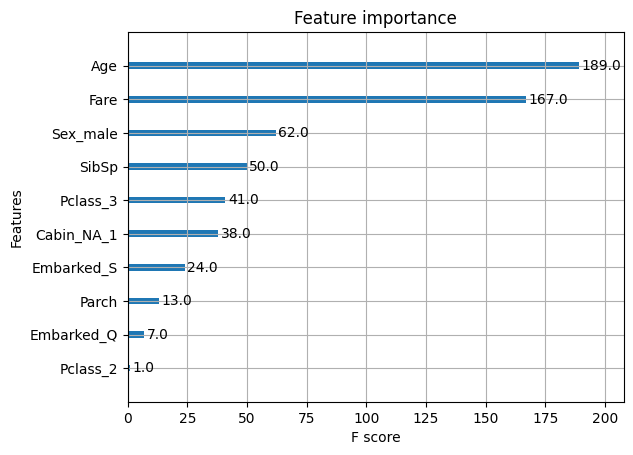

In [47]:
# XGB feature importance plot
plot_importance(gbm_model.best_estimator_)
X.columns;

In [46]:
# Let's look at the global feature importance plot of the EBM
ebm_global  = ebm_model.best_estimator_.explain_global()
show(ebm_global)

### Question 1 - Women and Children first
As we can see above and the histogram in section 2, the age and gender are both seen as part of the most important features of both the XGB and the EBM models.

On top of that, when looking at the specific feature-impact plots (similar to shap plots), we see that the positif impact of age is mostly until ~14 year old, which was the age where people at the beginning of the 20th century we seen more as young adults.

### Question 2 - Third class impact
As we can see in the 2 feature importance plots and the histogram seen in section 2, the boolean "are you in third class" feature was seen as a very important feature. On top of that, when looking at the feature's impact, we see that being in third class DID have a negative impact on your survival.

### Question 3 - Best score in Kaggle
To know which model is having the best score in the Kaggle competition, we need to send the predicted results to Kaggle and run the scoring function on them.

In [31]:
# Let's predict & write all submissions into csv files
for type, model in models.items():

    pred_proba= model.predict(test[features])
    pred_bin = np.where(pred_proba >= 0.5, 1, 0)

    output = pd.DataFrame({'PassengerId': test["PassengerId"], 
                            'Survived': pred_bin})
    output.to_csv(os.path.join(output_submissions,
                            f'submission_{type}_notebook.csv'),
                index=False)

Once scored, we have the following results:

- GLM: 0.76315
- EBM: 0.77272
- XGB: 0.78468

This time, the XGB is the best performing model, followed by EBM then GLM last.

### Question 4 - Feature assessment with EBM

It seems that the most important feature is the Sex. 

Then, very closely, follow the Class (especially the 3rd), Fare, Age and the fact to have a Cabin number written or not.